In [2]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import japanize_matplotlib
from pathlib import Path
import tqdm

from statsmodels.graphics.tsaplots import plot_acf


In [3]:
import pymc as pm
import arviz as az

In [4]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## 売上データのモデリング

### モデリング

In [5]:
# データ準備
beer_sales_df = pd.read_csv("data/2-4-1-beer-sales-1.csv")

print(beer_sales_df.shape)
print(beer_sales_df.head)

(100, 1)
<bound method NDFrame.head of      sales
0    87.47
1   103.67
2    83.29
3   131.91
4   106.59
..     ...
95  111.17
96   74.47
97   88.53
98   75.51
99   90.53

[100 rows x 1 columns]>


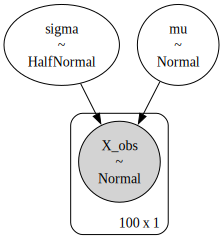

In [6]:
# コンテキスト定義
model = pm.Model()

# 確率モデルの定義
with model:
    # 事前分布: 各パラメータの分散を極端に大きくすることで無情報事前分布とみなせる
    mu = pm.Normal("mu", mu = 0, sigma = 1000000)
    sigma = pm.HalfNormal("sigma", sigma = 1000000)

    # 確率モデル
    X_obs = pm.Normal("X_obs", mu=mu, sigma=sigma, observed=beer_sales_df)

# 確率モデルの可視化
g = pm.model_to_graphviz(model)
display(g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 0 tune and 2_000 draw iterations (0 + 8_000 draws total) took 21 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 3967 divergences after tuning. Increase `target_accept` or reparameterize.


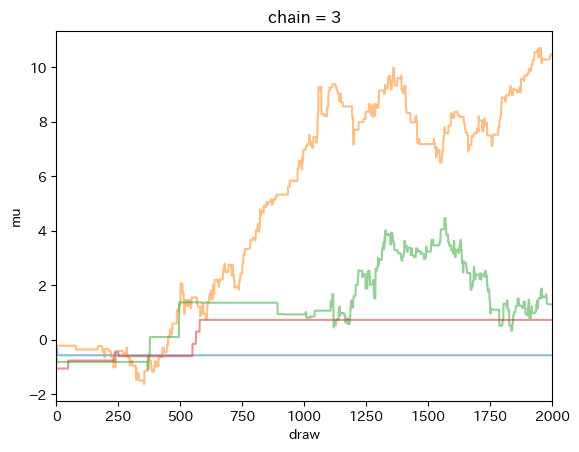

In [7]:
# サンプリング
with model:
    idata1 = pm.sample(
        chains = 4,
        tune = 0,
        draws = 2000,
        random_seed = 42
    )

# トレースプロット
idata1.posterior["mu"][0].plot(xlim=[0, 2000], alpha=0.5)
idata1.posterior["mu"][1].plot(xlim=[0, 2000], alpha=0.5)
idata1.posterior["mu"][2].plot(xlim=[0, 2000], alpha=0.5)
idata1.posterior["mu"][3].plot(xlim=[0, 2000], alpha=0.5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


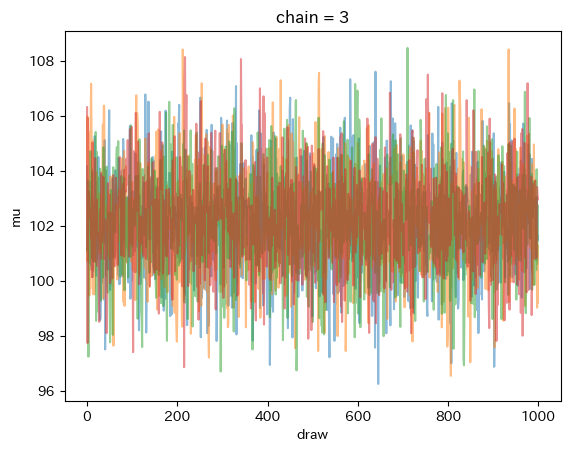

In [8]:
# サンプリング
with model:
    idata1 = pm.sample(
        chains = 4,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

# トレースプロット
idata1.posterior["mu"][0].plot(alpha=0.5)
idata1.posterior["mu"][1].plot(alpha=0.5)
idata1.posterior["mu"][2].plot(alpha=0.5)
idata1.posterior["mu"][3].plot(alpha=0.5)

# 上のセルを見るとtuneが0だとトータルの乱数生成量が同じでも収束していない。なぜ？アルゴリズムがburn-inの影響を受けるようなもの？

### 結果分析

In [9]:
# MCMCサンプルの代表値の計算
display(az.summary(idata1))

# az.summary()は全chainで統計量を計算している

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,102.166,1.834,98.879,105.733,0.028,0.020,4207.0,2776.0,1.0
sigma,18.190,1.289,15.818,20.601,0.021,0.015,3743.0,2596.0,1.0


In [10]:
mu0 = idata1.posterior["mu"][0].values
mu1 = idata1.posterior["mu"][1].values
mu2 = idata1.posterior["mu"][2].values
mu3 = idata1.posterior["mu"][3].values
mu_total = mu0 + mu1 +mu2 + mu3
print(mu_total.mean()/4)

sigma0 = idata1.posterior["sigma"][0].values
sigma1 = idata1.posterior["sigma"][1].values
sigma2 = idata1.posterior["sigma"][2].values
sigma3 = idata1.posterior["sigma"][3].values
sigma_total = sigma0 + sigma1 +sigma2 + sigma3
print(sigma_total.mean()/4)

102.16609617109654
18.189886635255913


In [11]:
idata1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Text(0.5, 1.0, 'トレースプロット: chain=4, バーンイン無し')

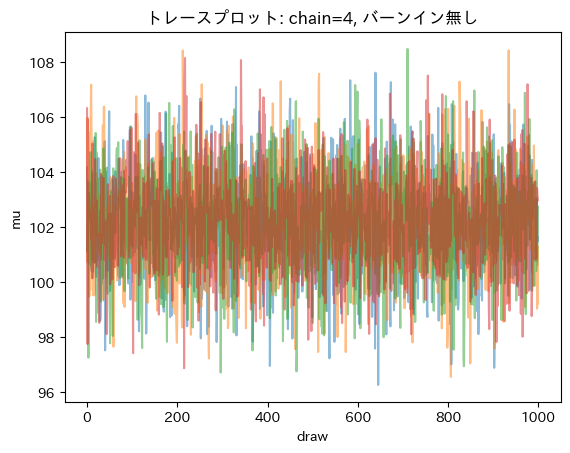

In [12]:
# トレースプロットの可視化(バーンイン無し) 
idata1.posterior["mu"][0].plot(alpha=0.5)
idata1.posterior["mu"][1].plot(alpha=0.5)
idata1.posterior["mu"][2].plot(alpha=0.5)
idata1.posterior["mu"][3].plot(alpha=0.5)

plt.title("トレースプロット: chain=4, バーンイン無し")

# バーンイン期間のデータの確認方法がわからない

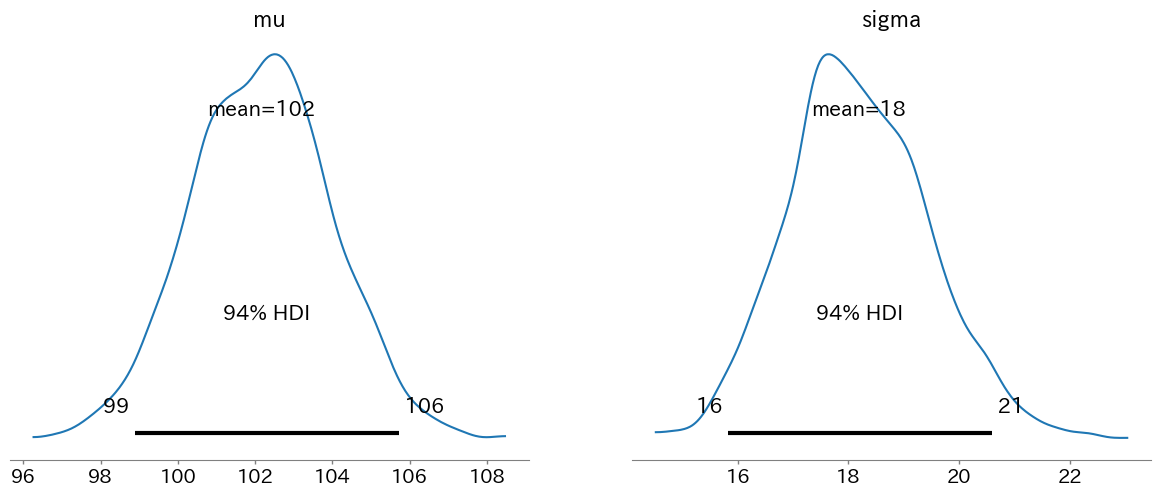

In [13]:
# 事後分布
ax = az.plot_posterior(idata1)

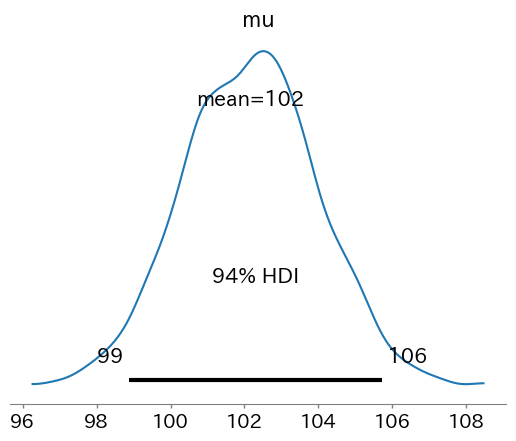

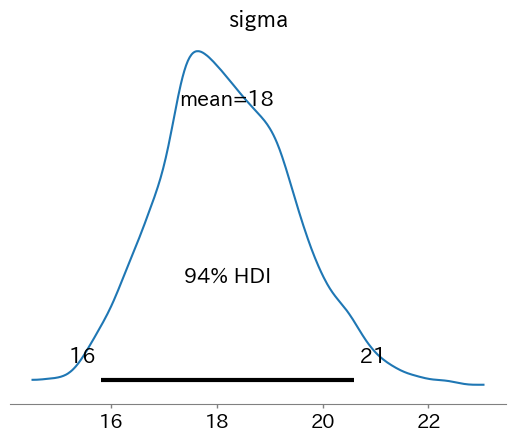

In [14]:
ax_mu = az.plot_posterior(idata1, var_names=["mu"])
ax_sigma = az.plot_posterior(idata1, var_names=["sigma"])

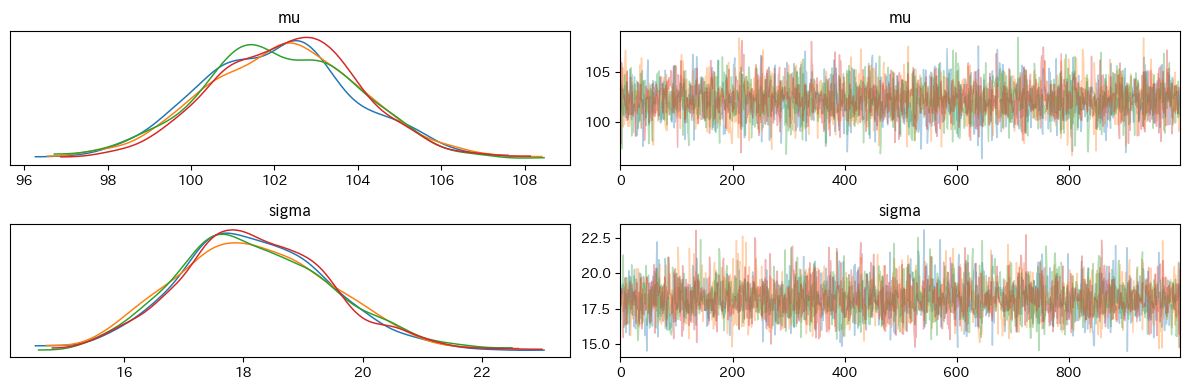

In [15]:
# トレースプロットの可視化(バーンイン無し)と事後分布を一括で可視化
az.plot_trace(idata1, compact = False)
plt.tight_layout()

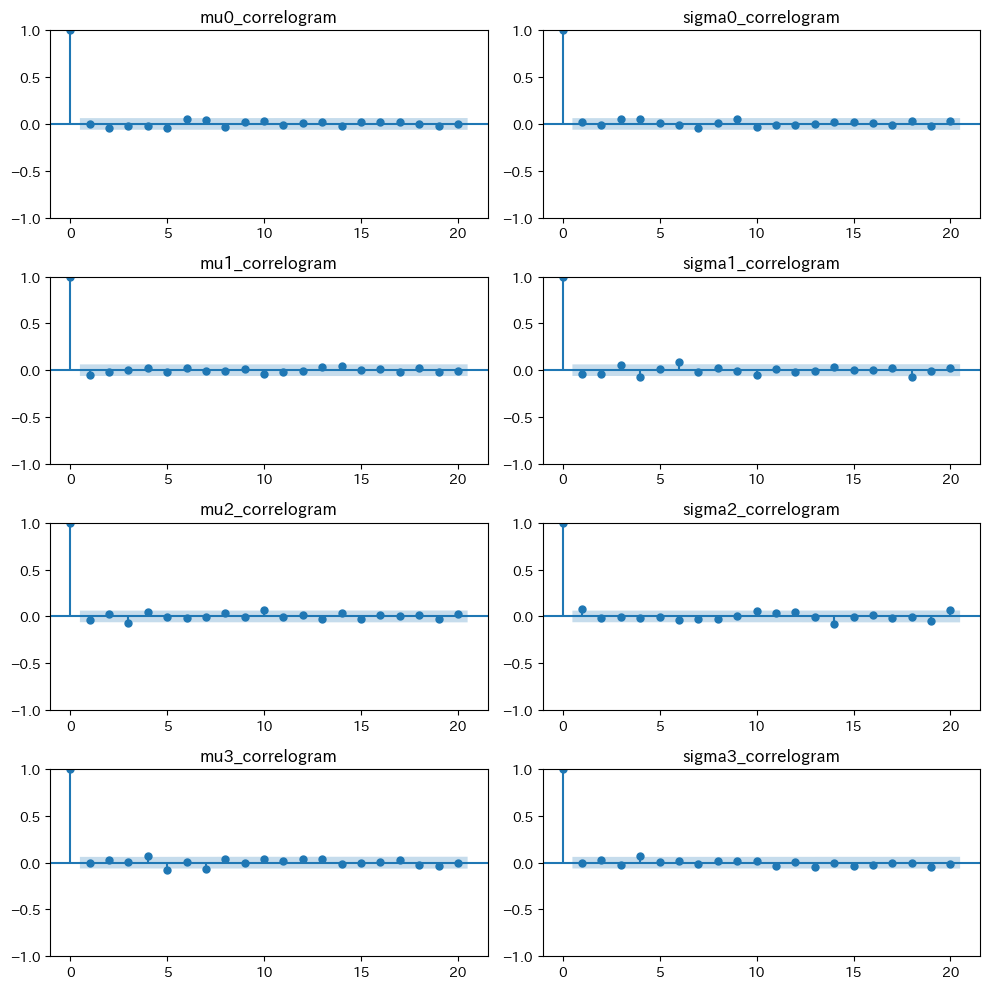

In [16]:
# 自己相関の評価
mu0 = idata1.posterior["mu"][0].values
mu1 = idata1.posterior["mu"][1].values
mu2 = idata1.posterior["mu"][2].values
mu3 = idata1.posterior["mu"][3].values
sigma0 = idata1.posterior["sigma"][0].values
sigma1 = idata1.posterior["sigma"][1].values
sigma2 = idata1.posterior["sigma"][2].values
sigma3 = idata1.posterior["sigma"][3].values

fig, ax = plt.subplots(4, 2, figsize=(10, 10))

plot_acf(mu0, lags=20, title="mu0_correlogram", ax=ax[0, 0])
plot_acf(mu1, lags=20, title="mu1_correlogram", ax=ax[1, 0])
plot_acf(mu2, lags=20, title="mu2_correlogram", ax=ax[2, 0])
plot_acf(mu3, lags=20, title="mu3_correlogram", ax=ax[3, 0])
plot_acf(sigma0, lags=20, title="sigma0_correlogram", ax=ax[0, 1])
plot_acf(sigma1, lags=20, title="sigma1_correlogram", ax=ax[1, 1])
plot_acf(sigma2, lags=20, title="sigma2_correlogram", ax=ax[2, 1])
plot_acf(sigma3, lags=20, title="sigma3_correlogram", ax=ax[3, 1])

plt.tight_layout()
plt.show();

## 小動物の発見個体数のモデリング

In [17]:
# データ準備
animal_num_df = pd.read_csv("data/2-5-1-animal-num.csv")

print(animal_num_df.shape)
print(animal_num_df.head)

(200, 1)
<bound method NDFrame.head of      animal_num
0             0
1             1
2             1
3             2
4             0
..          ...
195           1
196           0
197           2
198           0
199           2

[200 rows x 1 columns]>


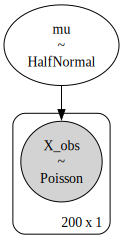

In [18]:
# 確率モデル定義
model = pm.Model()
with model:
    # 事前分布: 各パラメータの分散を極端に大きくすることで無情報事前分布とみなせる
    mu = pm.HalfNormal("mu", sigma = 1000000)

    # ポアソン分布
    X_obs = pm.Poisson("X_obs", mu = mu, observed = animal_num_df)

g = pm.model_to_graphviz(model)
display(g)    

In [19]:
# MCMCサンプリング
with model:
    idata2 = pm.sample(chains = 2,
                       tune = 1000,
                       draws = 1000,
                       random_seed= 42
                       )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


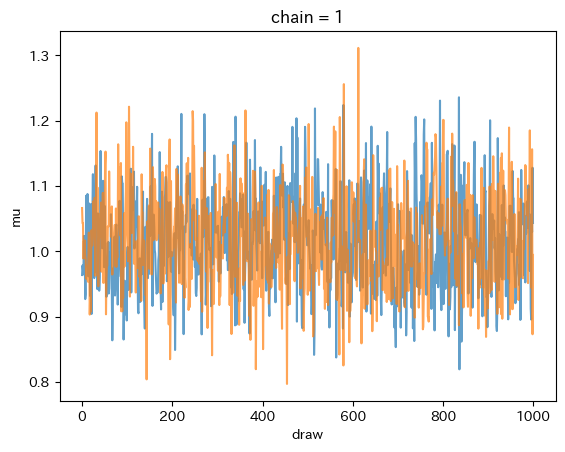

In [20]:
# トレースプロット
idata2.posterior["mu"][0].plot(alpha=0.7)
idata2.posterior["mu"][1].plot(alpha=0.7)

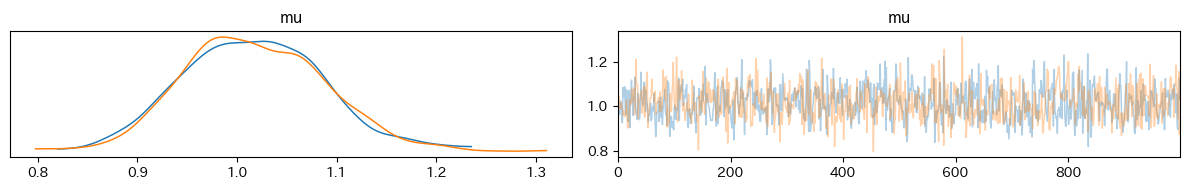

In [21]:
# MCMCサンプリングの可視化（パラメータの可視化）
az.plot_trace(idata2, compact=False)
plt.tight_layout();

In [22]:
# MCMCサンプルの統計量確認
az.summary(idata2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.017,0.07,0.878,1.137,0.002,0.002,907.0,1374.0,1.0


In [23]:
# 事後予測分布の確認: 得られたパラメータそれぞれの予測分布を確認(MCMCサンプル数の分布が得られる))
mu_ifr = idata2.posterior["mu"][0].values.reshape(-1, 1) # MCMCサンプルを1チェーン抽出

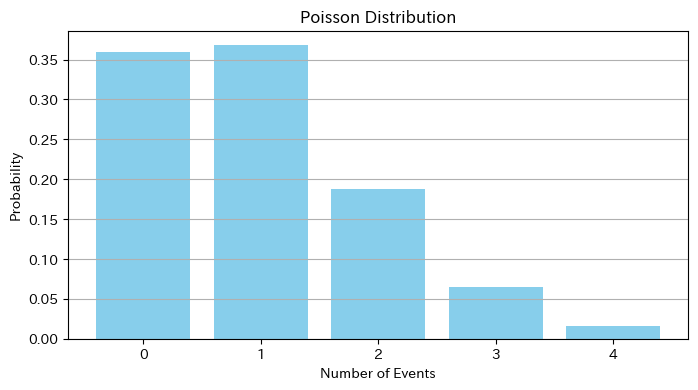

In [29]:
from scipy.stats import poisson

# ポアソン分布のPMFを計算
x = animal_num_df.values.reshape(-1,)
lambda_ = mu_ifr[5]
pmf = poisson.pmf(x, lambda_)

# プロット
plt.figure(figsize=(8, 4))
plt.bar(x, pmf, color='skyblue')
plt.title('Poisson Distribution')
plt.xlabel('Number of Events')
plt.ylabel('Probability')
plt.grid(axis='y')

# 描画
plt.show();

In [25]:
pmf

array([0.34316336, 0.36702992, 0.36702992, 0.19627818, 0.34316336,
       0.19627818, 0.06997636, 0.36702992, 0.36702992, 0.34316336,
       0.34316336, 0.34316336, 0.36702992, 0.36702992, 0.19627818,
       0.36702992, 0.36702992, 0.01871078, 0.36702992, 0.19627818,
       0.06997636, 0.34316336, 0.36702992, 0.34316336, 0.34316336,
       0.36702992, 0.34316336, 0.36702992, 0.19627818, 0.34316336,
       0.36702992, 0.36702992, 0.36702992, 0.34316336, 0.19627818,
       0.36702992, 0.19627818, 0.34316336, 0.36702992, 0.36702992,
       0.19627818, 0.36702992, 0.19627818, 0.36702992, 0.36702992,
       0.19627818, 0.34316336, 0.36702992, 0.36702992, 0.36702992,
       0.36702992, 0.19627818, 0.36702992, 0.34316336, 0.34316336,
       0.34316336, 0.34316336, 0.36702992, 0.36702992, 0.36702992,
       0.19627818, 0.34316336, 0.36702992, 0.34316336, 0.36702992,
       0.34316336, 0.36702992, 0.19627818, 0.34316336, 0.19627818,
       0.34316336, 0.19627818, 0.34316336, 0.34316336, 0.36702